# Inference on Australia data (WA) and observe effects of epsilon

## Load all information and modify them to the correct format

In [1]:
# Import libraries
import numpy as np
import math
import branchpro
import scipy.stats
import matplotlib
import plotly.graph_objects as go
from matplotlib import pyplot as plt
import os
import pandas as pd

In [2]:
# Read australia region data
region = 'WA'
path = os.path.join('../data_library/covid_australia/', '{}.csv'.format(region))
data = pd.read_csv(path)

In [3]:
time_key = 'Time'
num_timepoints = max(data[time_key])
data_times = data[time_key]

# Pad with zeros the time points where we have no information on
# the number of incidences
padded_inc_data = data.set_index(time_key).reindex(
    range(
        1, max(data_times)+1)
        ).fillna(0).reset_index()
locally_infected_cases = padded_inc_data['Incidence Number']
imported_cases = padded_inc_data['Imported Cases']

start_times = np.arange(1, num_timepoints+1, dtype=int)
times = np.arange(num_timepoints+1)

In [4]:
# Read serial interval
si_file = 'si-epinow'
path = os.path.join("../data_library/serial_interval", "{}.csv".format(si_file))
serial_interval = pd.read_csv(path, header=None)
serial_interval = serial_interval.fillna(0)


In [5]:
serial_intervals = serial_interval.values.T

In [6]:
# Plot (bar chart cases each day)
fig = go.Figure()

# Plot of incidences
fig.add_trace(
    go.Bar(
        x=times,
        y=locally_infected_cases,
        name='Local Incidences'
    )
)

fig.add_trace(
    go.Bar(
        x=times,
        y=imported_cases,
        name='Imported Incidences'
    )
)

# Add axis labels
fig.update_layout(
    xaxis_title='Time (days)',
    yaxis_title='New cases'
)

fig.show()

## Inference with epsilon equals 0

In [7]:
# Initialise parameter values
tau = 2
R_t_start = tau+1
a = 1
b = 0.8

# Transform our incidence data into pandas dataframes
inc_data = pd.DataFrame(
    {
        'Time': start_times,
        'Incidence Number': locally_infected_cases
    }
)

imported_inc_data = pd.DataFrame(
    {
        'Time': start_times,
        'Incidence Number': imported_cases
    }
)

# Run inference
epsilon = 0
inference = branchpro.LocImpBranchProPosteriorMultSI(
    inc_data=inc_data,
    imported_inc_data=imported_inc_data,
    epsilon=epsilon,
    daily_serial_intervals=serial_intervals,
    alpha=a,
    beta=1/b)

inference.run_inference(tau=tau)
intervals = inference.get_intervals(central_prob=.95)

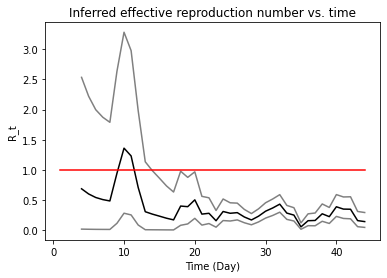

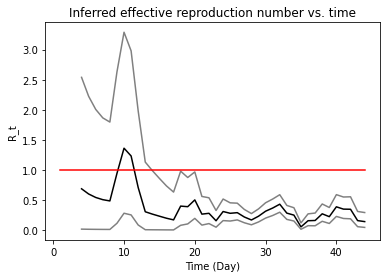

In [8]:
fig = plt.figure()
plt.plot(start_times[R_t_start:], intervals['Mean'], 'k')
plt.plot(start_times[R_t_start:], intervals['Lower bound CI'], 'gray')
plt.plot(start_times[R_t_start:], intervals['Upper bound CI'], 'gray')
plt.plot(start_times, np.ones(start_times.shape), 'red')
plt.xlabel('Time (Day)')
plt.ylabel('R_t')
plt.title('Inferred effective reproduction number vs. time')
plt.show()

## Comparison of inference results for different epsilon values

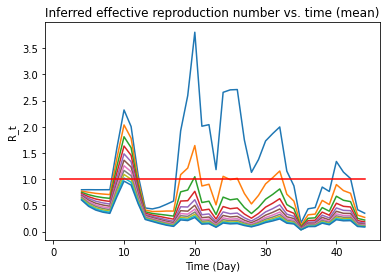

In [8]:
# Run inferences for different values of epsilon
column_names = ['Time Points', 'Mean', 'Lower bound CI', 'Upper bound CI', 'Central Probability', 'Epsilon']
all_intervals = pd.DataFrame(columns=column_names)
epsilon_range = np.arange(-1.0, 1.1, 0.2)
fig = plt.figure()
for epsilon in epsilon_range:
    inference = branchpro.LocImpBranchProPosteriorMultSI(
        inc_data=inc_data,
        imported_inc_data=imported_inc_data,
        epsilon=epsilon,
        daily_serial_intervals=serial_intervals,
        alpha=a,
        beta=1/b)

    inference.run_inference(tau=tau)
    intervals = inference.get_intervals(central_prob=0)
    intervals = intervals.append(inference.get_intervals(central_prob=.25))
    intervals = intervals.append(inference.get_intervals(central_prob=.95))
    temp = inference.get_intervals(central_prob=.95)
    plt.plot(start_times[R_t_start:], temp['Mean'])

    intervals['Epsilon'] = [epsilon] * len(intervals.index)
    
    intervals_chosen = pd.DataFrame(columns=intervals.columns)
    chosen_times = [10, 20, 30]
    for time_pt in chosen_times:
        intervals_chosen = intervals_chosen.append(
            intervals.loc[intervals['Time Points']== time_pt])

    all_intervals = all_intervals.append(intervals_chosen)
    
plt.plot(start_times, np.ones(start_times.shape), 'red')
plt.xlabel('Time (Day)')
plt.ylabel('R_t')
plt.title('Inferred effective reproduction number vs. time (mean)')
plt.show()

In [12]:
# Sort results
all_intervals.sort_values(by=['Time Points', 'Epsilon'], inplace=True)
all_intervals

,Time Points,Mean,Lower bound CI,Upper bound CI,Central Probability,Epsilon
6,10,2.321598,2.068528,2.068528,0.00,-1.0
6,10,2.321598,1.694533,2.495093,0.25,-1.0
6,10,2.321598,0.479217,5.593972,0.95,-1.0
6,10,2.035831,1.814523,1.814523,0.00,-0.8
6,10,2.035831,1.486510,2.186864,0.25,-0.8
...,...,...,...,...,...,...
26,30,0.190531,0.175608,0.200446,0.25,0.8
26,30,0.190531,0.121526,0.275252,0.95,0.8
26,30,0.173362,0.170787,0.170787,0.00,1.0
26,30,0.173362,0.159714,0.182391,0.25,1.0


In [13]:
# Create list of names for x-axis and traces
epsilon_range = np.around(epsilon_range,1)
num_epsilons = len(epsilon_range)
x_name = []
for i in range(num_epsilons):
    x_name.append(str(epsilon_range[i]))
trace_name = ['Day10', 'Day20', 'Day30']

# Plot (box plot for inference)
fig = go.Figure()

for i in range(3):
    fig.add_trace(
        go.Box(
            mean=all_intervals.loc[all_intervals['Central Probability']==0]['Mean'][i*num_epsilons:(i+1)*num_epsilons],
            median=all_intervals.loc[all_intervals['Central Probability']==0]['Lower bound CI'][i*num_epsilons:(i+1)*num_epsilons],
            q1=all_intervals.loc[all_intervals['Central Probability']==0.25]['Lower bound CI'][i*num_epsilons:(i+1)*num_epsilons],
            q3=all_intervals.loc[all_intervals['Central Probability']==0.25]['Upper bound CI'][i*num_epsilons:(i+1)*num_epsilons],
            upperfence=all_intervals.loc[all_intervals['Central Probability']==0.95]['Upper bound CI'][i*num_epsilons:(i+1)*num_epsilons],
            lowerfence=all_intervals.loc[all_intervals['Central Probability']==0.95]['Lower bound CI'][i*num_epsilons:(i+1)*num_epsilons],
            x=x_name,
            name=trace_name[i]
        )
    )
fig.update_layout(boxmode='group')
fig.show()

In [14]:
# Sort results
all_intervals.sort_values(by=['Epsilon','Time Points'], inplace=True)

# Create list of names for x-axis and traces
group_name = ['Day10', 'Day20', 'Day30']

# Plot (box plot for inference)
fig = go.Figure()

for i in range(11):
    fig.add_trace(
        go.Box(
            mean=all_intervals.loc[all_intervals['Central Probability']==0]['Mean'][i*3:(i+1)*3],
            median=all_intervals.loc[all_intervals['Central Probability']==0]['Lower bound CI'][i*3:(i+1)*3],
            q1=all_intervals.loc[all_intervals['Central Probability']==0.25]['Lower bound CI'][i*3:(i+1)*3],
            q3=all_intervals.loc[all_intervals['Central Probability']==0.25]['Upper bound CI'][i*3:(i+1)*3],
            upperfence=all_intervals.loc[all_intervals['Central Probability']==0.95]['Upper bound CI'][i*3:(i+1)*3],
            lowerfence=all_intervals.loc[all_intervals['Central Probability']==0.95]['Lower bound CI'][i*3:(i+1)*3],
            x=group_name,
            name=str(round(epsilon_range[i],1))
        )
    )
fig.update_layout(boxmode='group')
fig.show()